In [1]:
import spatialdata as sd
from concordex.neighbors import compute_neighbors
from concordex.tools import calculate_concordex

import os, sys
import pandas as pd

## Plotting
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import spatialdata_plot

/home/kayla-jackson/opt/anaconda3/envs/concordex-base/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/kayla-jackson/opt/anaconda3/envs/concordex-base/lib/python3.12/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
data_dir = "../data/raw/visium_hd"
visium_hd_zarr_path = os.path.join(data_dir, 'data.zarr')

In [3]:
sdata = sd.read_zarr(visium_hd_zarr_path)
# sdata

/home/kayla-jackson/opt/anaconda3/envs/concordex-base/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/kayla-jackson/opt/anaconda3/envs/concordex-base/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/kayla-jackson/opt/anaconda3/envs/concordex-base/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/kayla-jackson/opt/anaconda3/envs/concordex-base/lib/python3.12/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/kayla-jackson/opt/anaconda3/envs/concordex-base/lib/python3.12/site-packag

In [4]:
annotations_016 =  pd.read_csv(
  os.path.join(data_dir, "visium_hd_mouse_intestine_16um_graphclust.csv"))

Sanity check/EDA plots

In [5]:
annotations_016

,Barcode,Cluster
0,s_016um_00144_00175-1,3
1,s_016um_00145_00029-1,7
2,s_016um_00165_00109-1,8
3,s_016um_00297_00147-1,5
4,s_016um_00287_00091-1,17
...,...,...
91028,s_016um_00288_00288-1,12
91029,s_016um_00375_00231-1,14
91030,s_016um_00109_00223-1,1
91031,s_016um_00176_00108-1,6


In [6]:
data_extent = sd.get_extent(sdata["Visium_HD_Mouse_Small_Intestine_full_image"], coordinate_system="global")

queried_cytassist = sd.bounding_box_query(
    sdata["Visium_HD_Mouse_Small_Intestine_cytassist_image"],
    min_coordinate=[data_extent["x"][0], data_extent["y"][0]],
    max_coordinate=[data_extent["x"][1], data_extent["y"][1]],
    axes=("x", "y"),
    target_coordinate_system="global",
)
sdata["queried_cytassist"] = queried_cytassist

INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15..1.0].


INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06666667..1.0].


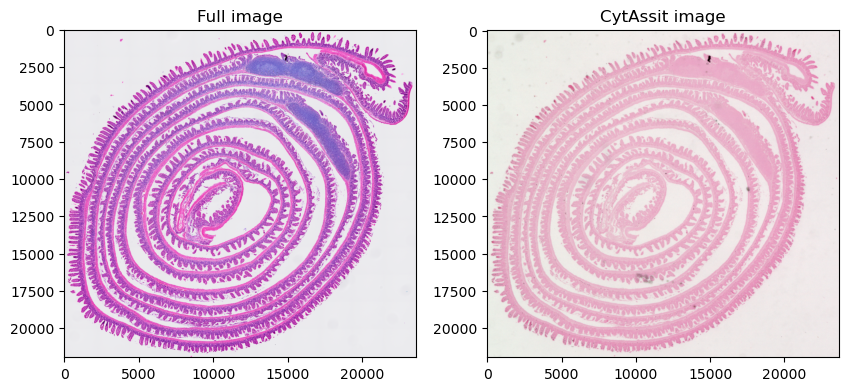

In [7]:
axes = plt.subplots(1, 2, figsize=(10, 5))[1].flatten()
sdata.pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.show(ax=axes[0], title="Full image")
sdata.pl.render_images("queried_cytassist").pl.show(ax=axes[1], title="CytAssit image")

# plt.savefig('vishd_he.png',dpi=500)

Subset sdata object

In [8]:
# Make var names unique
sdata.tables['square_016um'].var_names_make_unique()

In [9]:
adata_016 = sdata.tables['square_016um']

In [10]:
# prep annotations and merge
annotations_016 = annotations_016.set_index('Barcode')
annotations_016["cluster_str"] = annotations_016["Cluster"].transform(lambda x: f"cluster_{x}")
annotations_016["cluster_str"] = pd.Categorical(annotations_016["cluster_str"])

In [11]:
adata_016.obs = pd.merge(
    adata_016.obs, annotations_016, 
    how='left', 
    left_index=True, 
    right_index=True
)

In [12]:
%time calculate_concordex(adata_016, 'cluster_str', n_jobs=20, use_rep="spatial")

Computing nearest neighbors...

Computing neighborhood consolidation matrix...

CPU times: user 3min 51s, sys: 98.9 ms, total: 3min 51s
Wall time: 3min 44s


Cluster the NBC

In [16]:
X = adata_016.obsm['X_nbc']

for i in range(4, 8):
    print(f"Generating {i} clusters...\n")
    gm_key = f"gm_k{str(i).zfill(2)}"
    
    gm = GaussianMixture(n_components=i, random_state=2020).fit_predict(X)
    adata_016.obs[gm_key] = pd.Categorical(gm)

Generating 4 clusters...

Generating 5 clusters...

Generating 6 clusters...

Generating 7 clusters...



In [17]:
%load_ext watermark
%watermark -v -p concordex,scanpy,spatialdata

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.18.1

concordex  : 1.1.1
scanpy     : 1.11.1
spatialdata: 0.2.5.post0

